In [ ]:
!pip install SpeechRecognition

     |████████████████████████████████| 32.8MB 119kB/s 


In [ ]:
import speech_recognition as sr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def load_glove_embeddings(dim):
  #input: The dimensions of the embeddings to be loaded
  #output: A dictionary with every word and its vector

  GLOVE_DIM = dim #the dimensions of the embeddings
  #loading the GLOVE embeddings
  input_path = '/content/gdrive/MyDrive/'
  glove_file = 'glove.6B.' + str(GLOVE_DIM) + 'd.txt'
  emb_dict = {} #dictionary that stores each vector indexed by its word
  glove = open(input_path+glove_file)
  for line in glove:
    word, vector = line.split(maxsplit=1)
    vector = np.fromstring(vector,'f',sep=" ")
    emb_dict[word] = vector
  glove.close()
  return emb_dict

In [ ]:
text_data_path = "/content/gdrive/MyDrive/text data/"

In [ ]:
def load_train_data():
  #input: ideally the path should be input
  #output: training sentences and their labels

  train_text = open(text_data_path+"train.txt")
  angry_additional_text = open(text_data_path+"Emotion(angry).txt")

  #loading training data 
  train_sentences=[] #all sentences
  train_labels=[] #their labels
  train_as_str = "" #will hold all data as a string
  with train_text as f:
    train_as_str = f.read() #reading the training data
  train_as_str = train_as_str.lower()
  lines = train_as_str.split("\n") #each line has a sentence and a label, seperated with a semicolon
  for line in lines:
    lsen = line.split(";") #lsen has the sentence and its label
    if len(lsen) == 2 :
      train_sentences.append(lsen[0]) #storing the sentence
      train_labels.append(lsen[1]) #storing the label

  #now using the additional angry sentences. They are going to need further processing
  with angry_additional_text as f:
    train_as_str = f.read()
  train_as_str = train_as_str.lower()
  lines = train_as_str.split("\n")
  for line in lines:
    lsen = line.split(".")  #each line may have multiple sentences, hence split along dot
    train_sentences.extend(lsen) #adding all the sentences at the end
    train_labels.extend(["anger" for i in range(len(lsen))]) #adding "anger" the required number of times

  return train_sentences, train_labels

In [ ]:
def load_val_data():
  #input: ideally the path should be input
  #output: validation sentences and their labels

  #loading validation data 
  val_text = open(text_data_path+"val.txt")
  val_sentences=[] #all sentences
  val_labels=[] #their labels
  val_as_str = "" #will hold all data as a string
  with val_text as f:
    val_as_str = f.read() #reading the validation data
  val_as_str = val_as_str.lower()
  lines = val_as_str.split("\n") #each line has a sentence and a label, seperated with a semicolon
  for line in lines:
    lsen = line.split(";") #lsen has the sentence and its label
    if len(lsen) == 2 :
      val_sentences.append(lsen[0]) #storing the sentence
      val_labels.append(lsen[1]) #storing the label
  return val_sentences, val_labels

In [ ]:
def load_test_data():
  #input: ideally the path should be input
  #output: test sentences and their labels

  #loading test data 
  test_text = open(text_data_path+"test.txt")
  test_sentences=[] #all sentences
  test_labels=[] #their labels
  test_as_str = "" #will hold all data as a string
  with test_text as f:
    test_as_str = f.read() #reading the testing data
  test_as_str = test_as_str.lower()
  lines = test_as_str.split("\n") #each line has a sentence and a label, seperated with a semicolon
  for line in lines:
    lsen = line.split(";") #lsen has the sentence and its label
    if len(lsen) == 2 :
      test_sentences.append(lsen[0]) #storing the sentence
      test_labels.append(lsen[1]) #storing the label
  return test_sentences, test_labels

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
def create_vectorizer(sentence_data_for_vocab, num_most_freq_words=20000, max_word_length=24):
  #input: sentence_data_for_vocab: a list containing sentences from which the vectorizer create its vocabulary, which it maps to indices
  #       num_most_freq_words: int storing the number of most frequent words that will contribute to the vocabulary
  #       max_word_length: The length of the ouput int sentence from the vectorizer. Smaller sentences are padded, larger ones are truncated
  #output: vectorizer: the vectorizer which can be used to vectorize other sentences
  #        voc: a list of all words in descending order of their frequency of occurance
  #        word_index: dictionary storing words and their indices

  #vectorizer is used to convert sentences to a list of their word indices:
  vectorizer = TextVectorization(max_tokens=num_most_freq_words, output_sequence_length=max_word_length) #maximum number of words to be take= 20000, max length of sentence=24 words
  text_ds = tf.data.Dataset.from_tensor_slices(train_sentences).batch(128) #breaks into batches of 128 sentences. Not needed really, but okay
  vectorizer.adapt(text_ds)
  voc = vectorizer.get_vocabulary()
  word_index = dict(zip(voc, range(len(voc)))) #a dictionary with words and indices
  return vectorizer, voc, word_index

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding

In [ ]:
#main
GLOVE_DIM = 300
LENGTH_SENTENCE = 24
emb_dict = load_glove_embeddings(GLOVE_DIM)
train_sentences, train_labels= load_train_data()
val_sentences, val_labels= load_val_data()
test_sentences, test_labels= load_test_data()
vectorizer, voc, word_index = create_vectorizer(train_sentences,20000,LENGTH_SENTENCE)

#Embedding Layer Creation

num_tokens = len(voc) + 2
embedding_dim = GLOVE_DIM
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = emb_dict.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


Converted 14298 words (1110 misses)


In [ ]:
from tensorflow.keras import layers
kernel_size = [3,5,7,9]
parallel_layers = []
int_sequences_input = keras.Input(shape=(LENGTH_SENTENCE,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
for i in range(4):  
  x = layers.Conv1D(64, kernel_size[i], activation="relu")(embedded_sequences)
  x = layers.Reshape((24-kernel_size[i]+1,64,1) , input_shape=(24-kernel_size[i]+1,64,))(x)
  x = layers.MaxPooling2D((2,2), padding="valid")(x) 
  parallel_layers.append(x)  

x = tf.keras.layers.Concatenate(axis=1)(parallel_layers)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x= layers.Dropout(0.75)(x)
x=layers.Dense(50,activation="relu")(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(int_sequences_input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 24, 300)      4623000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 22, 64)       57664       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20, 64)       96064       embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
numerical_labels = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "sadness": 3,    
    "love": 4,
    "surprise": 5,
}
x_train = vectorizer(np.array([[s] for s in train_sentences])).numpy()
x_val = vectorizer(np.array([[s] for s in val_sentences])).numpy()

y_train = np.array([[numerical_labels[s]] for s in train_labels])
y_val = np.array([[numerical_labels[s]] for s in val_labels])

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
136/136 [==============================] - 22s 155ms/step - loss: 1.7441 - acc: 0.2349 - val_loss: 1.5468 - val_acc: 0.4660
Epoch 2/20
136/136 [==============================] - 21s 154ms/step - loss: 1.5123 - acc: 0.3904 - val_loss: 1.3272 - val_acc: 0.5290
Epoch 3/20
136/136 [==============================] - 21s 155ms/step - loss: 1.2866 - acc: 0.5126 - val_loss: 1.1176 - val_acc: 0.5885
Epoch 4/20
136/136 [==============================] - 21s 155ms/step - loss: 1.0671 - acc: 0.5993 - val_loss: 0.9706 - val_acc: 0.6630
Epoch 5/20
136/136 [==============================] - 21s 152ms/step - loss: 0.8610 - acc: 0.6852 - val_loss: 0.8414 - val_acc: 0.6995
Epoch 6/20
136/136 [==============================] - 21s 152ms/step - loss: 0.6767 - acc: 0.7496 - val_loss: 0.7471 - val_acc: 0.7445
Epoch 7/20
136/136 [==============================] - 21s 151ms/step - loss: 0.5478 - acc: 0.8018 - val_loss: 0.7339 - val_acc: 0.7520
Epoch 8/20
136/136 [==============================] - 2

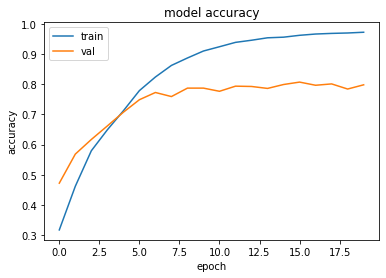

In [ ]:
import keras
from matplotlib import pyplot as plt
#history = model.fit(tx, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_test = vectorizer(np.array([[s] for s in test_sentences])).numpy()

y_test = np.array([[numerical_labels[s]] for s in test_labels])

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=1)

63/63 [==============================] - 1s 16ms/step - loss: 1.1474 - acc: 0.7800


In [ ]:
%cd '/content/gdrive/MyDrive/Models'
model.save('Words_Based_Detector.h5')

/content/gdrive/MyDrive/Models
